# Evaluating speech polarization over time

In [1]:
path = "/home/piotr/projects/twitter"
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import gc
import json
import pickle
import datetime
import random
from collections import defaultdict
from tqdm.notebook import tqdm, trange
from linearmodels.iv.absorbing import Interaction
import itertools
from functools import partial
import os
import ast
import pdb
import sys
sys.path.append(os.path.join(path, 'src'))
from twitter_models.polarization import ModelPolarization
from twitter_tools.utils import read_files, clean_tweets, filter_data
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from linearmodels import RandomEffects
import seaborn as sns
path_stopwords = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(path_stopwords, 'r') as f:
    for line in f:
        word = line.strip('\n')
        if word != 'nie':
            stopwords.append(word)

In [2]:
gov = pickle.load(open(os.path.join(path, 'data/sample/gov_sample.pickle'),"rb"))
opp = pickle.load(open(os.path.join(path, 'data/sample/opp_sample.pickle'),"rb"))
parties = {k:"gov" for k in gov}
parties.update({k:"opp" for k in opp})
path_data = os.path.join(path, "data/clean")


#Get random assignment
random_keys = list(parties.keys()); random.shuffle(random_keys) #randomize keys
random_values = list(parties.values()); random.shuffle(random_values) #randomize values
randomized = dict(zip(random_keys, random_values)) #zip into dict

The call below writes a new file that contains data from the day-level files filtered using the data filtering function defined above:

In [3]:
def plot_aggregated(data, **kwargs):
    aggregated = {day:{k + "_" + k1:v1 for k, v in res.items() if k != "disaggregated" for k1, v1 in v.items()} for day, res in data.items()}
    aggregated = pd.DataFrame(aggregated).T.reset_index()
    fig, ax = plt.subplots(1,figsize = (10,10))
    date = np.array(list(results.keys()))
    ax.plot(date, aggregated["true_estimate"], lw = 3, label='Leave out estimator', color='blue')
    ax.plot(date, aggregated["random_estimate"], lw = 3, linestyle = "--", label='Random assignment', color='red')
    ax.fill_between(date, aggregated["true_upper_ci"], aggregated["true_lower_ci"], facecolor='blue', alpha=0.5)
    ax.fill_between(date, aggregated["random_upper_ci"], aggregated["random_lower_ci"], facecolor='red', alpha=0.5)
    ax.legend(loc='upper left')
    ax.xaxis.set_tick_params(rotation=45)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.set_xlabel('Date')
    ax.set_ylabel('Polarization')
    ax.grid()
    plt.show()

In [4]:
DROP_IDS = json.load(open(os.path.join(path, 'results/cleaning/DROP_IDS.json'), 'r'))
def filter_fun(df, cols: list, drop_ids: list, stopwords: list):
    df = df.loc[np.logical_not(df.id_str.isin(drop_ids)),:]
    df = df.loc[np.logical_not(df.retweet.apply(lambda x: ast.literal_eval(x))),:]
    df['lemmatized'] = df.lemmatized.astype(str).apply(lambda x: " ".join([x for x in x.split() if x not in stopwords]))
    return df
ff = partial(filter_fun, cols = ['lemmatized', 'day', 'source', 'user-id_str'], drop_ids = DROP_IDS, 
             stopwords = stopwords)

*The leave-out estimator of partisanship is obtained using the following process. Each user's speech-generating process is assumed to follow a multinomial distribution over the possible phrase set, where each phrase is picked with a certain choice probability. The*


\begin{equation}
\hat{\pi}_{t}^{LO} = \frac{1}{2} \frac{1}{|R_{t}|} \sum_{i \in R_{t}} \hat{q}_{i,t}  \cdot \hat{p}_{-i,t} +  \frac{1}{2} \frac{1}{|D_{t}|} \sum_{i \in D_{t}} \hat{q}_{i,t}  \cdot (1 - \hat{p}_{-i,t})\\
\end{equation}


$\hat{p}_{-i,t} = \hat{q}_{-i,t}^{R} / (\hat{q}_{-i,t}^{R} + \hat{q}_{-,it}^{D})$ is the probability of an observer with a neutral prior assigning a speaker to government based only on a given phrase



$\hat{q}_{i,t} = c_{i,t} / m_{i,t}$ are the phrase frequencies for speaker $i$ at time $t$ 




*The estimation of confidence interval for the leave-out estimator is obtained via sub-sampling, using the procedure described by Gentzkow et al. (2019), based on Politis et al. (1990) procedure. Specifically:*

(THE CI FORMULA GOES HERE)

## 1. The leave-out estimator of partisanship
- using all data
- excluding retweets
- minimum number of bigram/unigram occurence in one day - 40

In [15]:
if os.path.isfile(os.path.join(path, "results/polarization/polarization_no_retweets.p")):
    results = pickle.load(open(os.path.join(path, "results/polarization/polarization_no_retweets.p"),"rb"))
else:
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(path_data, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day]["true"] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 50, ngram_range = (1,2))
        results[day]["random"] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int = 100)
    results = dict(results) #convert defaultdict to dict
    pickle.dump(results, open(os.path.join(path, "results/polarization/polarization_no_retweets.p"),"wb"))

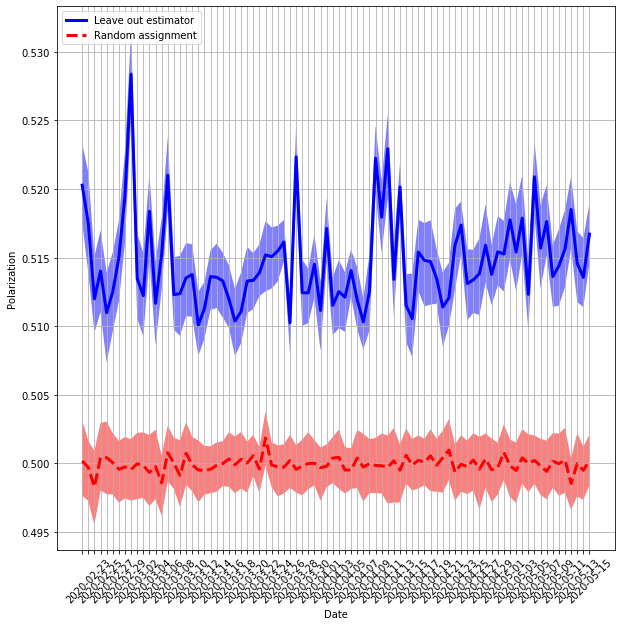

In [16]:
plot_aggregated(results)

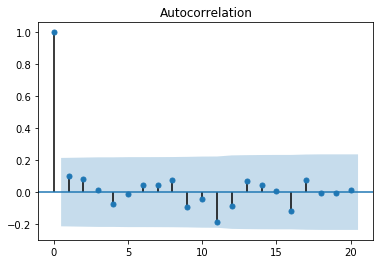

In [17]:
plot_acf(np.array([v['true']['estimate'] for v in results.values()]))
plt.show()

## 2. The leave-out estimator of partisanship  - Covid
- excluding retweets
- only coronavirus-related content
- minimum lenght of tweet - 5 (lemmatized, including stopwords)
- maximum minimum number of bigram occurence in one day - 5

In [6]:
if os.path.isfile(os.path.join(path, "results/polarization/polarization_covid.p")):
    results = pickle.load(open(os.path.join(path, "results/polarization/polarization_covid.p"),"rb"))
else:
    wirus_vocab  = "korona|koronawirus|wirus|epidemia|pandemia|choroba|covid|covid19|maseczka|sars|zarażenie|zarażony|zarażać|chorować|ofiary|ofiara|corona|lockdown|szpital"
    DROP_IDS = json.load(open(os.path.join(path, 'results/cleaning/DROP_IDS.json'), 'r'))
    def filter_fun(df, cols: list, drop_ids: list, stopwords: list):
        df = df.loc[np.logical_not(df.id_str.isin(drop_ids)),:]
        df = df.loc[np.logical_not(df.retweet.apply(lambda x: ast.literal_eval(x))),:]
        df['lemmatized'] = df.lemmatized.astype(str).apply(lambda x: " ".join([x for x in x.split() if x not in stopwords]))
        wirus_ind = df.lemmatized.str.contains(wirus_vocab)
        df = df.iloc[np.where(wirus_ind)[0]]
        return df
    ff = partial(filter_fun, cols = ['lemmatized', 'day', 'source', 'user-id_str'], drop_ids = DROP_IDS, 
                 stopwords = stopwords)
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(path_data, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"] #get tweets
        day = data['day'].unique()[0]
        try:
            model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
            results[day]["true"] = model.estimate(parties, users, tweets, 
                                                                   level = "aggregate", conf_int = 100)
            #randomization
            random_parties = data["user-id_str"].astype(str).map(randomized)
            model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
            results[day]["random"] = model.estimate(random_parties, users, tweets, 
                                                                   level = "aggregate", conf_int = 100)
        except ValueError:
            results[day]['true'] = dict()
            results[day]['random'] = dict()
    results = dict(results) #convert defaultdict to dict
    pickle.dump(results, open(os.path.join(path, "results/polarization/polarization_covid.p"),"wb"))

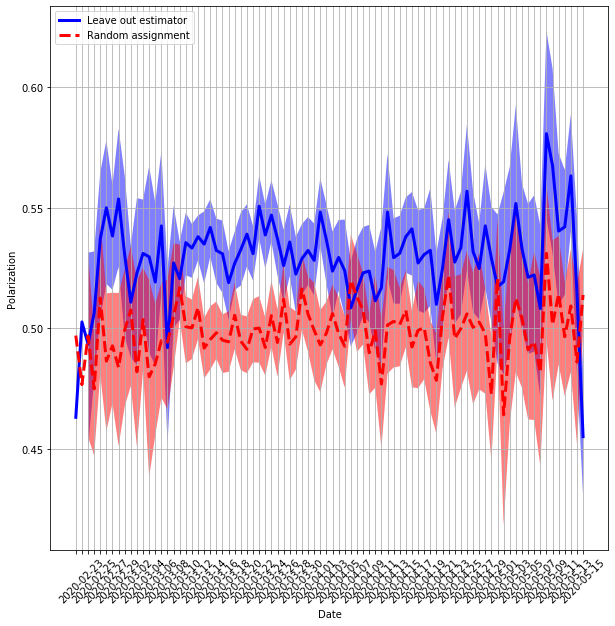

In [7]:
plot_aggregated(results)

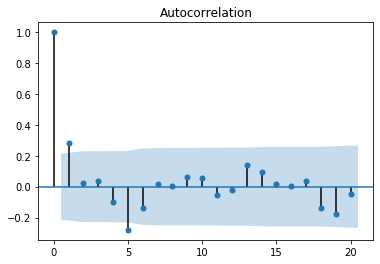

In [14]:
plot_acf(np.array([v['true']['estimate'] for v in results.values()]))
plt.show()

## 3. The leave-out estimator of partisanship  - Elections
- excluding retweets
- only election-related content
- minimum lenght of tweet - 5 (lemmatized, including stopwords)
- maximum minimum number of bigram occurence in one day - 5

In [22]:
if os.path.isfile(os.path.join(path, "results/polarization/polarization_elections.p")):
    results = pickle.load(open(os.path.join(path, "results/polarization/polarization_elections.p"),"rb"))
else:
    election_vocab  = "wybory|wyborczy|wybór|kampania|kampanijny|prezydent|prezydencki|głos|głosować|głosowanie"
    DROP_IDS = json.load(open(os.path.join(path, 'results/cleaning/DROP_IDS.json'), 'r'))
    def filter_fun(df, cols: list, drop_ids: list, stopwords: list):
        df = df.loc[np.logical_not(df.id_str.isin(drop_ids)),:]
        df = df.loc[np.logical_not(df.retweet.apply(lambda x: ast.literal_eval(x))),:]
        df['lemmatized'] = df.lemmatized.astype(str).apply(lambda x: " ".join([x for x in x.split() if x not in stopwords]))
        ind = df.lemmatized.str.contains(election_vocab)
        df = df.iloc[np.where(ind)[0]]
        return df
    ff = partial(filter_fun, cols = ['lemmatized', 'day', 'source', 'user-id_str'], drop_ids = DROP_IDS, 
                 stopwords = stopwords)
    results = defaultdict(lambda: dict().fromkeys(["true","random"])) #store for each day
    for data in tqdm(read_files(path_data, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"] #get tweets
        day = data['day'].unique()[0]
        try:
            model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
            results[day]["true"] = model.estimate(parties, users, tweets, 
                                                                   level = "aggregate", conf_int = 100)
            #randomization
            random_parties = data["user-id_str"].astype(str).map(randomized)
            model = ModelPolarization(parties = ["gov", "opp"], limit = 5)
            results[day]["random"] = model.estimate(random_parties, users, tweets, 
                                                                   level = "aggregate", conf_int = 100)
        except ValueError:
            results[day]['true'] = dict()
            results[day]['random'] = dict()
    results = dict(results) #convert defaultdict to dict
    pickle.dump(results, open(os.path.join(path, "results/polarization/polarization_elections.p"),"wb"))

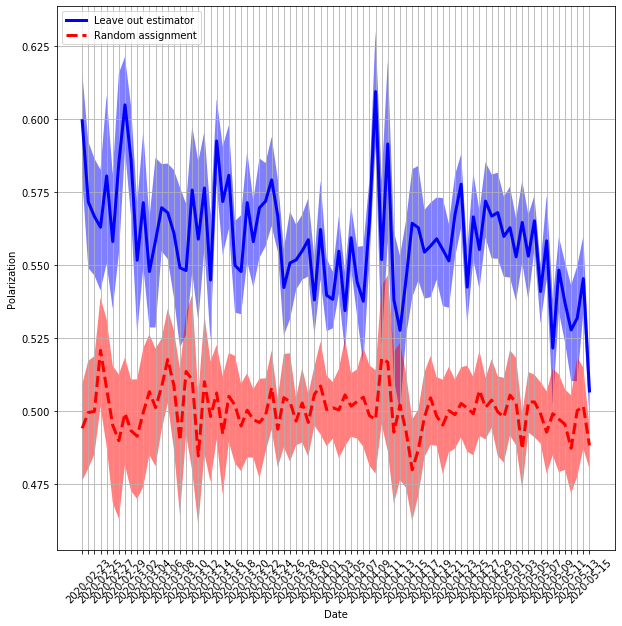

In [25]:
plot_aggregated(results)

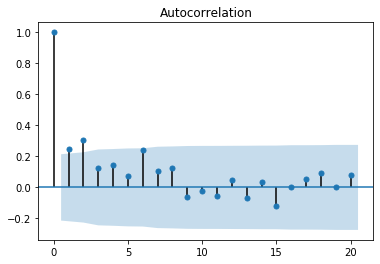

In [27]:
plot_acf(np.array([v['true']['estimate'] for v in results.values()]))

### User-level analysis:

In [7]:
if os.path.isfile(os.path.join(path, "results/polarization/polarization_users.p")):
    results = pickle.load(open(os.path.join(path, "results/polarization/polarization_users.p"),"rb"))
else:
    results = dict()
    for data in tqdm(read_files(path_data, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day] = model.estimate(parties, users, tweets,level = "speaker")
    pickle.dump(results, open(os.path.join(path, "results/polarization/polarization_users.p"),"wb"))

In [8]:
data = pd.DataFrame(columns = ['day','user-id_str','score'])
for day in tqdm(results):
    tmp = pd.DataFrame.from_dict(results[day]).T
    tmp.columns = ['score','user-id_str']
    tmp['day'] = day
    tmp = tmp[data.columns]
    data = data.append(tmp)
data['score'] = data['score'].astype(np.float64)

In [9]:
data.groupby('user-id_str').agg({'score':['mean', 'count']})

score      
                         mean count
user-id_str                        
1000073228935749635  0.514984    36
1000110258           0.256479     2
1000250244091863040  0.510907    28
1000279095182352384  0.518075    36
1000356907142479872  0.533483     2
...                       ...   ...
998250092            0.489349    82
998288203797946368   0.615886     4
998483760420139008   0.542039    14
998836233282387968   0.476248    35
999889490            0.520252    70

[8787 rows x 2 columns]

#### Merge polarization scores with network connectivity data
- merge the daily number of retweets, replies and quotes with the leave-out polarization estimates for each user-day
- for each user, measure the number of connections with his own party and the opposing party using the function `get_opposites`

In [10]:
#load connections data (retweets, replies, etc)
connections = pickle.load(open(os.path.join(path, "data/connections.p"), "rb"))
connections = pd.DataFrame(connections)
connections.index.names = ['day', 'user-id_str']
connections.reset_index(inplace = True)
connections['source'] = np.where(connections['user-id_str'].isin(gov), 'gov', 'opp')
cols = [col for col in connections.columns if 'gov' in col or 'opp' in col]
connections[cols] = connections[cols].apply(lambda x: x/connections.total)

data = pd.merge(data, connections) #merge with rt information

In [11]:
stats = pd.read_csv(os.path.join(path, 'data/overview.csv'), index_col = 0, dtype = str)
stats = stats[['user-id_str','day','full_text','user-friends_count','user-followers_count']]
data = pd.merge(data, stats)

In [12]:
def get_opposites(data, cols):
    for col in cols:
        gov_col = col + '_gov'
        opp_col = col + '_opp'
        data[col + '_own'] = np.where(data['source'] == 'gov', data[gov_col], data[opp_col])
        data[col + '_other'] = np.where(data['source'] == 'gov', data[opp_col], data[gov_col])
    return data

In [13]:
data = get_opposites(data, ['in_reply_to_user_id_str', 
                                'retweeted_status-user-id_str',
                                'quoted_status-user-id_str', 'sum'])

In [14]:
data['sum_own'] = np.round(data['sum_own']*data['full_text'].astype(int))
data['sum_other'] = np.round(data['sum_other']*data['full_text'].astype(int))

#### Plot average connectivity with own party members/other party members against the average polarization score of a user

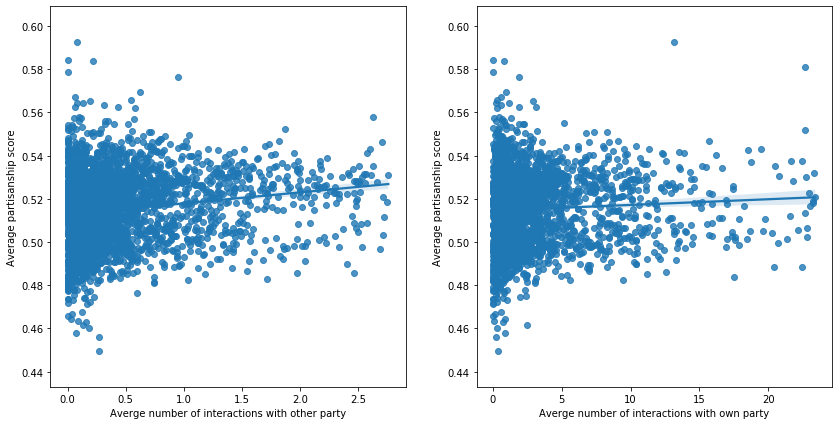

In [124]:
data_plot = data.groupby('user-id_str').agg({'score':['mean','count'],'sum_own':'mean','sum_other':'mean'})


f, ax = plt.subplots(1, 2, figsize=(14, 7))
ax = ax.ravel()
ind = data_plot[('sum_other','mean')] < np.quantile(data_plot[('sum_other','mean')], 0.99)
ind &= data_plot[('score','count')] > 40
data_plot_cut = data_plot[ind]
sns.regplot(data_plot_cut[('sum_other','mean')],data_plot_cut[('score','mean')],ax = ax[0])
ax[0].set_xlabel('Averge number of interactions with other party')
ax[0].set_ylabel('Average partisanship score')


ind = data_plot[('sum_own','mean')] < np.quantile(data_plot[('sum_own','mean')], 0.99)
ind &= data_plot[('score','count')] > 40
data_plot_cut = data_plot[ind]
sns.regplot(data_plot_cut[('sum_own','mean')],data_plot_cut[('score','mean')],ax = ax[1])
ax[1].set_xlabel('Averge number of interactions with own party')
ax[1].set_ylabel('Average partisanship score')
plt.show()

#### Prepare data for panel analysis:
- add constant term
- add lag terms

In [15]:
data["date_num"] = pd.to_datetime(data["day"], format = "%Y-%m-%d").astype(int) #numeric index for date
data = data.set_index(["user-id_str","date_num"]) #set index for panel models
data = data.dropna() #drop missing
data = sm.add_constant(data) #constant
cols_to_shift = [col for col in data.columns if 'own' in col or 'other' in col]
cols_shift = [c + '_lag' for c in cols_to_shift]
data[cols_shift] = data[cols_to_shift].apply(lambda x: x.shift(-1))
data['score_lag'] = data['score'].shift(-1)

In [16]:
mod = RandomEffects(data['score'], data[['const','sum_own_lag', 'sum_other_lag']])
res = mod.fit(cov_type = 'clustered')
print(res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  score   R-squared:                        0.5292
Estimator:              RandomEffects   R-squared (Between):             -0.0002
No. Observations:              259055   R-squared (Within):            9.965e-05
Date:                Fri, Jul 17 2020   R-squared (Overall):          -9.929e-05
Time:                        13:52:35   Log-likelihood                 3.945e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.456e+05
Entities:                        8783   P-value                           0.0000
Avg Obs:                       29.495   Distribution:                F(2,259052)
Min Obs:                       1.0000                                           
Max Obs:                       84.000   F-statistic (robust):             8.7893
                            

In [17]:
mod = RandomEffects(data['score'], data[['const','score_lag', 'sum_own_lag', 'sum_other_lag']])
res = mod.fit(cov_type = 'clustered')
print(res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  score   R-squared:                        0.5795
Estimator:              RandomEffects   R-squared (Between):              0.0998
No. Observations:              259055   R-squared (Within):               0.1059
Date:                Fri, Jul 17 2020   R-squared (Overall):              0.1172
Time:                        13:52:47   Log-likelihood                 4.091e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                    1.19e+05
Entities:                        8783   P-value                           0.0000
Avg Obs:                       29.495   Distribution:                F(3,259051)
Min Obs:                       1.0000                                           
Max Obs:                       84.000   F-statistic (robust):             3348.9
                            

### Tweet-level analysis
- obtain the polarization scores for individual tweets, to manually evaluate which Tweets get highest/lowest polarization scores

In [5]:
if os.path.isfile(os.path.join(path, "results/polarization/polarization_tweets.p")):
    results = pickle.load(open(os.path.join(path, "results/polarization/polarization_tweets.p"),"rb"))
else:
    results = dict()
    for data in tqdm(read_files(path_data, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        ids = data['id_str'].astype(str)
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day] = model.estimate(parties, users, tweets, text_id = ids, level = "speech")
    pickle.dump(results, open(os.path.join(path, "results/polarization/polarization_tweets.p"),"wb"))

In [16]:
data = pd.DataFrame(columns = ['score','id_str','day'])
for k in tqdm(results):
    tmp = pd.DataFrame(results[k]).T
    tmp['day'] = k
    tmp.columns = data.columns
    data = data.append(tmp)
data['text'] = np.nan
for df in tqdm(read_files(path_data, ndays = 84, dtype = str, filter_fun = ff)):
    text_dict = df.set_index('id_str')['full_text'].to_dict()
    ind = data.day == df.day.unique()[0]
    data.loc[ind]['text'] = data.loc[ind]['id_str'].map(text_dict)

### Vocabulary analysis
- Evaluate polarity of users' vocabulary - see which tokens were most and least associated with the government and how that has changed over time

In [125]:
if os.path.isfile(os.path.join(path, "results/polarization/polarization_vocab.p")):
    results = pickle.load(open(os.path.join(path, "results/polarization/polarization_vocab.p"),"rb"))
else:
    results = dict()
    for data in tqdm(read_files(path_data, ndays = 84, dtype = str, filter_fun = ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[day] = model.get_posteriors(parties, users, tweets)
    pickle.dump(results, open(os.path.join(path, "results/polarization/polarization_vocab.p"),"wb"))

In [126]:
def plot_word_partisanship(results, word):
    changes = {day:values[word] if word in values else None for day, values in results.items()}
    changes = pd.DataFrame.from_dict(changes, orient = 'index', columns = [word])
    changes = changes.interpolate(method = 'linear', limit_direction = 'both')
    return changes

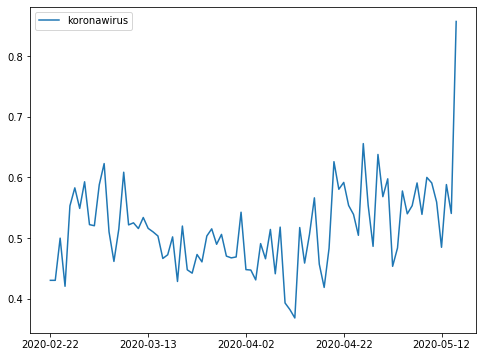

In [129]:
fig, ax = plt.subplots(figsize = (8, 6))
plot_word_partisanship(results, 'koronawirus').plot(ax = ax)
plt.show()

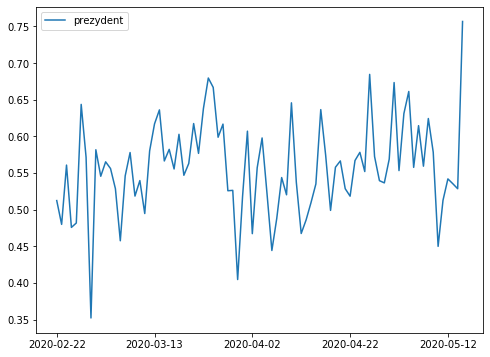

In [130]:
fig, ax = plt.subplots(figsize = (8, 6))
plot_word_partisanship(results, 'prezydent').plot(ax = ax)
plt.show()

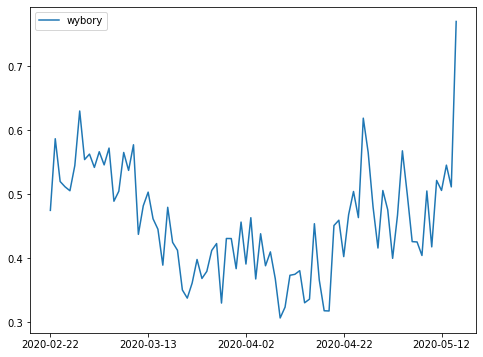

In [131]:
fig, ax = plt.subplots(figsize = (8, 6))
plot_word_partisanship(results, 'wybory').plot(ax = ax)
plt.show()